<a href="https://colab.research.google.com/github/Tuhinmajumder/EVA4_S6/blob/master/S6_MNIST_TuhinMajumder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=28, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(28),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=28, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
           Dropout-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 28, 24, 24]           4,032
              ReLU-5           [-1, 28, 24, 24]               0
       BatchNorm2d-6           [-1, 28, 24, 24]              56
           Dropout-7           [-1, 28, 24, 24]               0
            Conv2d-8           [-1, 10, 24, 24]             280
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           1,440
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14             [

Without Regularization

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
prediction=[]
target_y=[]

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            target_y.append(target)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            prediction.append(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()
 

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) #
scheduler = StepLR(optimizer, step_size=8,gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)



  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.11394073814153671 Batch_id=468 Accuracy=84.07: 100%|██████████| 469/469 [00:14<00:00, 33.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1047, Accuracy: 9715/10000 (97.15%)

EPOCH: 1


Loss=0.09156516939401627 Batch_id=468 Accuracy=97.00: 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0494, Accuracy: 9858/10000 (98.58%)

EPOCH: 2


Loss=0.13717924058437347 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:14<00:00, 33.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9871/10000 (98.71%)

EPOCH: 3


Loss=0.019729113206267357 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:14<00:00, 32.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9881/10000 (98.81%)

EPOCH: 4


Loss=0.06284371763467789 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:14<00:00, 32.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9906/10000 (99.06%)

EPOCH: 5


Loss=0.06116251274943352 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:14<00:00, 32.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9915/10000 (99.15%)

EPOCH: 6


Loss=0.05762996897101402 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:14<00:00, 33.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9924/10000 (99.24%)

EPOCH: 7


Loss=0.04456107318401337 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:14<00:00, 32.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9898/10000 (98.98%)

EPOCH: 8


Loss=0.08239763230085373 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:14<00:00, 32.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9931/10000 (99.31%)

EPOCH: 9


Loss=0.03154416382312775 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:14<00:00, 33.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.040768664330244064 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:14<00:00, 32.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9937/10000 (99.37%)

EPOCH: 11


Loss=0.12059272080659866 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9937/10000 (99.37%)

EPOCH: 12


Loss=0.06115564703941345 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:14<00:00, 32.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9938/10000 (99.38%)

EPOCH: 13


Loss=0.019781768321990967 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:14<00:00, 33.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.02999485470354557 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 33.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9940/10000 (99.40%)

EPOCH: 15


Loss=0.07306557893753052 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:14<00:00, 37.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9937/10000 (99.37%)

EPOCH: 16


Loss=0.030527638271450996 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:14<00:00, 39.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)

EPOCH: 17


Loss=0.07180476933717728 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 32.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9940/10000 (99.40%)

EPOCH: 18


Loss=0.10770926624536514 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:14<00:00, 32.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99.41%)

EPOCH: 19


Loss=0.01641223393380642 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:14<00:00, 32.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9940/10000 (99.40%)

EPOCH: 20


Loss=0.0337146632373333 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:14<00:00, 32.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9937/10000 (99.37%)

EPOCH: 21


Loss=0.06558860093355179 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 33.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9942/10000 (99.42%)

EPOCH: 22


Loss=0.05359695479273796 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 32.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9942/10000 (99.42%)

EPOCH: 23


Loss=0.05524780973792076 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 32.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9938/10000 (99.38%)

EPOCH: 24


Loss=0.052052900195121765 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:14<00:00, 33.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9940/10000 (99.40%)

EPOCH: 25


Loss=0.017581140622496605 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:14<00:00, 32.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9938/10000 (99.38%)

EPOCH: 26


Loss=0.025012388825416565 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:14<00:00, 32.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9942/10000 (99.42%)

EPOCH: 27


Loss=0.0790371522307396 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9940/10000 (99.40%)

EPOCH: 28


Loss=0.04489300772547722 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 33.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9936/10000 (99.36%)

EPOCH: 29


Loss=0.029770398512482643 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:14<00:00, 32.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99.41%)

EPOCH: 30


Loss=0.038052748888731 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9940/10000 (99.40%)

EPOCH: 31


Loss=0.0340355709195137 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:14<00:00, 32.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9939/10000 (99.39%)

EPOCH: 32


Loss=0.008486166596412659 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:14<00:00, 32.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)

EPOCH: 33


Loss=0.021788904443383217 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 33.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9939/10000 (99.39%)

EPOCH: 34


Loss=0.018320759758353233 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 32.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9936/10000 (99.36%)

EPOCH: 35


Loss=0.01882222853600979 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 32.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9941/10000 (99.41%)

EPOCH: 36


Loss=0.07516515254974365 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:14<00:00, 32.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9936/10000 (99.36%)

EPOCH: 37


Loss=0.05438510701060295 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:14<00:00, 32.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9940/10000 (99.40%)

EPOCH: 38


Loss=0.023404903709888458 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:14<00:00, 32.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9936/10000 (99.36%)

EPOCH: 39


Loss=0.08088498562574387 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:14<00:00, 32.54it/s]



Test set: Average loss: 0.0207, Accuracy: 9935/10000 (99.35%)



W/O Regularization:
Results:
1.	Parameters: 9996
2.	Best Training Accuracy: 98.92
3.	Best Test Accuracy: 99.35
4.	Epoch:40

In [0]:
model1=model
device1=device
test_loader1=test_loader

In [0]:

train_losses1=train_losses
test_losses1=test_losses
train_acc1=train_acc
test_acc1=test_acc

**L2 Regularization**

In [0]:
model =  Net().to(device)
optimizer1 = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.0001) # L2 Regularization
scheduler = StepLR(optimizer, step_size=8,gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer1, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.09260053187608719 Batch_id=468 Accuracy=85.41: 100%|██████████| 469/469 [00:13<00:00, 41.06it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0816, Accuracy: 9764/10000 (97.64%)

EPOCH: 1


Loss=0.06551510840654373 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:13<00:00, 34.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9859/10000 (98.59%)

EPOCH: 2


Loss=0.039563894271850586 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:13<00:00, 34.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9890/10000 (98.90%)

EPOCH: 3


Loss=0.023824742063879967 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:13<00:00, 34.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9906/10000 (99.06%)

EPOCH: 4


Loss=0.018762456253170967 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:14<00:00, 37.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9888/10000 (98.88%)

EPOCH: 5


Loss=0.1519625186920166 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:13<00:00, 34.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9916/10000 (99.16%)

EPOCH: 6


Loss=0.08006695657968521 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:14<00:00, 32.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9921/10000 (99.21%)

EPOCH: 7


Loss=0.1566580981016159 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:13<00:00, 34.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.0662849172949791 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:14<00:00, 37.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.10072239488363266 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:13<00:00, 33.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9922/10000 (99.22%)

EPOCH: 10


Loss=0.029080266132950783 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:13<00:00, 34.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.007346148137003183 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:13<00:00, 41.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9931/10000 (99.31%)

EPOCH: 12


Loss=0.008899077773094177 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:13<00:00, 33.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9932/10000 (99.32%)

EPOCH: 13


Loss=0.008541266433894634 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 34.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9927/10000 (99.27%)

EPOCH: 14


Loss=0.08038973063230515 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:13<00:00, 34.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9930/10000 (99.30%)

EPOCH: 15


Loss=0.03350449725985527 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:13<00:00, 33.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9934/10000 (99.34%)

EPOCH: 16


Loss=0.025233736261725426 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:13<00:00, 34.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9942/10000 (99.42%)

EPOCH: 17


Loss=0.01975659467279911 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:13<00:00, 39.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9943/10000 (99.43%)

EPOCH: 18


Loss=0.0893472209572792 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 33.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9935/10000 (99.35%)

EPOCH: 19


Loss=0.012429505586624146 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:14<00:00, 33.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9940/10000 (99.40%)

EPOCH: 20


Loss=0.04586878791451454 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:13<00:00, 35.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9924/10000 (99.24%)

EPOCH: 21


Loss=0.01458702515810728 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:13<00:00, 34.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9940/10000 (99.40%)

EPOCH: 22


Loss=0.04787981137633324 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:13<00:00, 34.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9941/10000 (99.41%)

EPOCH: 23


Loss=0.024717086926102638 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:13<00:00, 34.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9934/10000 (99.34%)

EPOCH: 24


Loss=0.019637232646346092 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:13<00:00, 35.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9941/10000 (99.41%)

EPOCH: 25


Loss=0.013003632426261902 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:13<00:00, 35.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9933/10000 (99.33%)

EPOCH: 26


Loss=0.003982777241617441 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:13<00:00, 35.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9941/10000 (99.41%)

EPOCH: 27


Loss=0.025188537314534187 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 34.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9943/10000 (99.43%)

EPOCH: 28


Loss=0.05369985103607178 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 34.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9941/10000 (99.41%)

EPOCH: 29


Loss=0.11519693583250046 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 35.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9937/10000 (99.37%)

EPOCH: 30


Loss=0.014749658294022083 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:13<00:00, 34.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9934/10000 (99.34%)

EPOCH: 31


Loss=0.10693151503801346 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 34.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9942/10000 (99.42%)

EPOCH: 32


Loss=0.011044840328395367 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:13<00:00, 35.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9937/10000 (99.37%)

EPOCH: 33


Loss=0.02011042833328247 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 34.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9941/10000 (99.41%)

EPOCH: 34


Loss=0.018789192661643028 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 34.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9936/10000 (99.36%)

EPOCH: 35


Loss=0.0055605568923056126 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 34.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9946/10000 (99.46%)

EPOCH: 36


Loss=0.0250043123960495 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:13<00:00, 35.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9934/10000 (99.34%)

EPOCH: 37


Loss=0.043182048946619034 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 41.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9936/10000 (99.36%)

EPOCH: 38


Loss=0.00630699098110199 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:13<00:00, 34.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9941/10000 (99.41%)

EPOCH: 39


Loss=0.010837823152542114 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 34.12it/s]



Test set: Average loss: 0.0170, Accuracy: 9944/10000 (99.44%)



In [0]:
train_losses2=train_losses
test_losses2=test_losses
train_acc2=train_acc
test_acc2=test_acc
model2=model
device2=device
test_loader2=test_loader

L2 Regularization:
Results:
1.	Parameters: 9996
2.	Best Training Accuracy: 99.11
3.	Best Test Accuracy: 99.44
4.	Epoch:40

**L1 Regularization**

In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train1(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
      zero_vector=torch.rand_like(param)*0
      reg_loss += l1_crit(param,zero_vector)


    factor = 0.0005
    loss += factor * reg_loss
    #loss=loss1+loss2
    train_losses.append(loss)



    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test1(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    adv_examples = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            final_pred = output.max(1, keepdim=True)[1]
            target_1 =target[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    

In [0]:
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # L1 Regularization
scheduler = StepLR(optimizer, step_size=8,gamma=0.1)

examples=[]
acuracies=[]
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train1(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test1(model, device, test_loader)


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.3588244318962097 Batch_id=468 Accuracy=85.91: 100%|██████████| 469/469 [00:15<00:00, 30.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1189, Accuracy: 9676/10000 (96.76%)

EPOCH: 1


Loss=0.27433693408966064 Batch_id=468 Accuracy=96.82: 100%|██████████| 469/469 [00:15<00:00, 29.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0683, Accuracy: 9812/10000 (98.12%)

EPOCH: 2


Loss=0.23778899013996124 Batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:15<00:00, 29.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0598, Accuracy: 9823/10000 (98.23%)

EPOCH: 3


Loss=0.2522573471069336 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:15<00:00, 30.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9866/10000 (98.66%)

EPOCH: 4


Loss=0.2371218204498291 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:15<00:00, 39.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9864/10000 (98.64%)

EPOCH: 5


Loss=0.25115954875946045 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:15<00:00, 30.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0531, Accuracy: 9836/10000 (98.36%)

EPOCH: 6


Loss=0.2345394790172577 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:15<00:00, 31.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Accuracy: 9859/10000 (98.59%)

EPOCH: 7


Loss=0.23260067403316498 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:15<00:00, 30.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0534, Accuracy: 9835/10000 (98.35%)

EPOCH: 8


Loss=0.21779142320156097 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:15<00:00, 31.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9922/10000 (99.22%)

EPOCH: 9


Loss=0.16229337453842163 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:15<00:00, 30.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.18977737426757812 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:14<00:00, 31.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.17422913014888763 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:15<00:00, 30.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9935/10000 (99.35%)

EPOCH: 12


Loss=0.2600284814834595 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:15<00:00, 37.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.16557353734970093 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:14<00:00, 31.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9922/10000 (99.22%)

EPOCH: 14


Loss=0.16001161932945251 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 31.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9927/10000 (99.27%)

EPOCH: 15


Loss=0.14976660907268524 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:14<00:00, 37.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9931/10000 (99.31%)

EPOCH: 16


Loss=0.16914650797843933 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:15<00:00, 30.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Loss=0.26283368468284607 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:14<00:00, 31.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9940/10000 (99.40%)

EPOCH: 18


Loss=0.16311122477054596 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:14<00:00, 31.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9935/10000 (99.35%)

EPOCH: 19


Loss=0.17538169026374817 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:15<00:00, 30.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9935/10000 (99.35%)

EPOCH: 20


Loss=0.2397199422121048 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 31.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9933/10000 (99.33%)

EPOCH: 21


Loss=0.1581992357969284 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 32.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9936/10000 (99.36%)

EPOCH: 22


Loss=0.17352047562599182 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 33.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9937/10000 (99.37%)

EPOCH: 23


Loss=0.15291814506053925 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9931/10000 (99.31%)

EPOCH: 24


Loss=0.18808352947235107 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 33.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9930/10000 (99.30%)

EPOCH: 25


Loss=0.13975541293621063 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 33.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9934/10000 (99.34%)

EPOCH: 26


Loss=0.15280631184577942 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 33.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9933/10000 (99.33%)

EPOCH: 27


Loss=0.16696254909038544 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:14<00:00, 39.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)

EPOCH: 28


Loss=0.20521211624145508 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:14<00:00, 33.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9933/10000 (99.33%)

EPOCH: 29


Loss=0.17600178718566895 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 33.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9933/10000 (99.33%)

EPOCH: 30


Loss=0.13499362766742706 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 33.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9936/10000 (99.36%)

EPOCH: 31


Loss=0.137132927775383 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 32.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9935/10000 (99.35%)

EPOCH: 32


Loss=0.157205268740654 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 33.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)

EPOCH: 33


Loss=0.168385311961174 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:13<00:00, 33.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9936/10000 (99.36%)

EPOCH: 34


Loss=0.19824793934822083 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:13<00:00, 33.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9935/10000 (99.35%)

EPOCH: 35


Loss=0.15041187405586243 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 39.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9934/10000 (99.34%)

EPOCH: 36


Loss=0.13757263123989105 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:14<00:00, 32.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9934/10000 (99.34%)

EPOCH: 37


Loss=0.14281560480594635 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 33.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9936/10000 (99.36%)

EPOCH: 38


Loss=0.14972487092018127 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 33.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9934/10000 (99.34%)

EPOCH: 39


Loss=0.177679181098938 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 32.78it/s]



Test set: Average loss: 0.0214, Accuracy: 9934/10000 (99.34%)



In [0]:
train_losses3=train_losses
test_losses3=test_losses
train_acc3=train_acc
test_acc3=test_acc
model3=model
device3=device
test_loader3=test_loader

L1 Regularization:
Results:
1.	Parameters: 9996
2.	Best Training Accuracy: 98.97
3.	Best Test Accuracy: 99.34
4.	Epoch:40

 **L1 and L2 Regularization**

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.0001) # L1 Regularization
scheduler = StepLR(optimizer, step_size=8,gamma=0.1)

examples=[]
acuracies=[]
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train1(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test1(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.3807772994041443 Batch_id=468 Accuracy=84.38: 100%|██████████| 469/469 [00:15<00:00, 29.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1297, Accuracy: 9638/10000 (96.38%)

EPOCH: 1


Loss=0.2866199016571045 Batch_id=468 Accuracy=96.93: 100%|██████████| 469/469 [00:15<00:00, 30.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0980, Accuracy: 9729/10000 (97.29%)

EPOCH: 2


Loss=0.23879945278167725 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:15<00:00, 37.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0764, Accuracy: 9771/10000 (97.71%)

EPOCH: 3


Loss=0.22598505020141602 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:15<00:00, 29.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9866/10000 (98.66%)

EPOCH: 4


Loss=0.26667168736457825 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:15<00:00, 33.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0506, Accuracy: 9831/10000 (98.31%)

EPOCH: 5


Loss=0.2336256206035614 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:15<00:00, 30.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 9829/10000 (98.29%)

EPOCH: 6


Loss=0.19270437955856323 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:15<00:00, 29.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9894/10000 (98.94%)

EPOCH: 7


Loss=0.29321742057800293 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:15<00:00, 30.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9863/10000 (98.63%)

EPOCH: 8


Loss=0.20627574622631073 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:15<00:00, 29.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)

EPOCH: 9


Loss=0.24011246860027313 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:15<00:00, 31.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9938/10000 (99.38%)

EPOCH: 10


Loss=0.15715232491493225 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:15<00:00, 30.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.17716073989868164 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:14<00:00, 31.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9938/10000 (99.38%)

EPOCH: 12


Loss=0.1796691119670868 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:14<00:00, 31.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9936/10000 (99.36%)

EPOCH: 13


Loss=0.1583644598722458 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:15<00:00, 31.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9929/10000 (99.29%)

EPOCH: 14


Loss=0.1491803228855133 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:14<00:00, 32.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9934/10000 (99.34%)

EPOCH: 15


Loss=0.13693687319755554 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:14<00:00, 31.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9940/10000 (99.40%)

EPOCH: 16


Loss=0.13762834668159485 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:14<00:00, 32.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9939/10000 (99.39%)

EPOCH: 17


Loss=0.16461318731307983 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:14<00:00, 31.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9947/10000 (99.47%)

EPOCH: 18


Loss=0.14549854397773743 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:15<00:00, 31.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9944/10000 (99.44%)

EPOCH: 19


Loss=0.18326595425605774 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:14<00:00, 32.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9943/10000 (99.43%)

EPOCH: 20


Loss=0.14039625227451324 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 32.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9947/10000 (99.47%)

EPOCH: 21


Loss=0.14905720949172974 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:15<00:00, 31.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9941/10000 (99.41%)

EPOCH: 22


Loss=0.15421849489212036 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:14<00:00, 31.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9946/10000 (99.46%)

EPOCH: 23


Loss=0.13595916330814362 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:14<00:00, 31.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9941/10000 (99.41%)

EPOCH: 24


Loss=0.13959985971450806 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 34.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9944/10000 (99.44%)

EPOCH: 25


Loss=0.18606755137443542 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:14<00:00, 31.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9946/10000 (99.46%)

EPOCH: 26


Loss=0.14851024746894836 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:14<00:00, 32.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9943/10000 (99.43%)

EPOCH: 27


Loss=0.1494046449661255 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 31.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9943/10000 (99.43%)

EPOCH: 28


Loss=0.1473218947649002 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:15<00:00, 31.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9944/10000 (99.44%)

EPOCH: 29


Loss=0.1633502095937729 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:14<00:00, 42.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9945/10000 (99.45%)

EPOCH: 30


Loss=0.1588909924030304 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 32.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9943/10000 (99.43%)

EPOCH: 31


Loss=0.19922703504562378 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:14<00:00, 32.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9944/10000 (99.44%)

EPOCH: 32


Loss=0.17357231676578522 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:14<00:00, 31.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9948/10000 (99.48%)

EPOCH: 33


Loss=0.15404187142848969 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9947/10000 (99.47%)

EPOCH: 34


Loss=0.13468818366527557 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 32.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9942/10000 (99.42%)

EPOCH: 35


Loss=0.1891774833202362 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:14<00:00, 32.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9944/10000 (99.44%)

EPOCH: 36


Loss=0.2089446485042572 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:14<00:00, 33.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9943/10000 (99.43%)

EPOCH: 37


Loss=0.20425860583782196 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:14<00:00, 40.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9946/10000 (99.46%)

EPOCH: 38


Loss=0.13948816061019897 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9943/10000 (99.43%)

EPOCH: 39


Loss=0.14893606305122375 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:14<00:00, 32.00it/s]



Test set: Average loss: 0.0207, Accuracy: 9947/10000 (99.47%)



L1,L2 Regularization:
Results:
1.	Parameters: 9996
2.	Best Training Accuracy: 98.90
3.	Best Test Accuracy: 99.47
4.	Epoch:40

In [0]:
train_losses4=train_losses
test_losses4=test_losses
train_acc4=train_acc
test_acc4=test_acc
model4=model
device4=device
test_loader4=test_loader

# Let's Train and test our model

This time let's add a scheduler for out LR. 

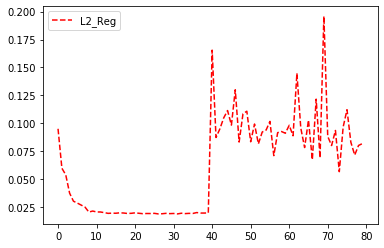

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

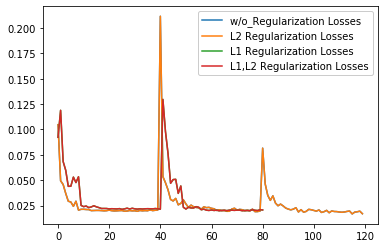

In [0]:
plt.plot( test_losses1, label='w/o_Regularization Losses')
plt.plot( test_losses2, label='L2 Regularization Losses')
plt.plot( test_losses3, label='L1 Regularization Losses')
plt.plot( test_losses4, label='L1,L2 Regularization Losses')
plt.legend(framealpha=1, frameon=True);

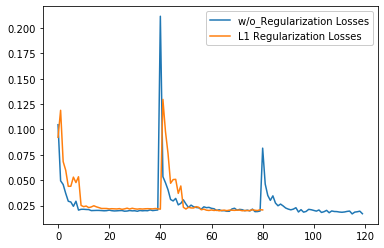

In [43]:
plt.plot( test_losses1, label='w/o_Regularization Losses')
#plt.plot( test_losses2, label='L2 Regularization Losses')
plt.plot( test_losses3, label='L1 Regularization Losses')
#plt.plot( test_losses4, label='L1,L2 Regularization Losses')
plt.legend(framealpha=1, frameon=True);

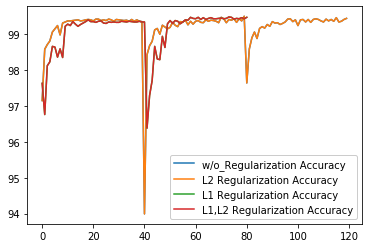

In [0]:
plt.plot( test_acc1, label='w/o_Regularization Accuracy')
plt.plot( test_acc2, label='L2 Regularization Accuracy')
plt.plot( test_acc3, label='L1 Regularization Accuracy')
plt.plot( test_acc4, label='L1,L2 Regularization Accuracy')
plt.legend(framealpha=1, frameon=True);

Text(0.5, 1.0, 'Test Accuracy')

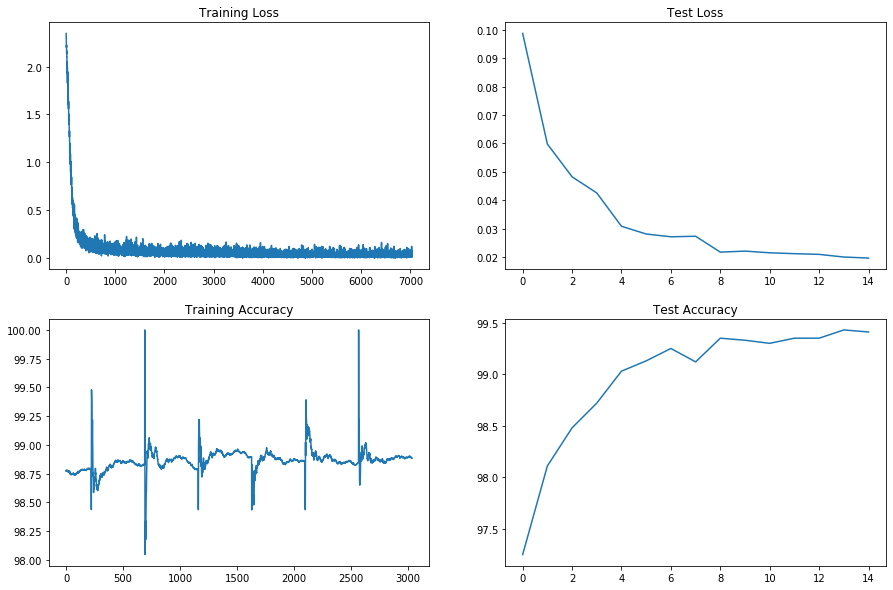

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:

def get_misclassified(model, device, test_loader):
    misclassified = []
    misclassified_pred = []
    misclassified_target = []
    # put the model to evaluation mode
    model.eval()
    # turn off gradients
    with torch.no_grad():
        for data, target in test_loader:
            # move them to the respective device
            data, target = data.to(device), target.to(device)
            # do inferencing
            output = model(data)
            # get the predicted output
            pred = output.argmax(dim=1, keepdim=True)

            # get the current misclassified in this batch
            list_misclassified = (pred.eq(target.view_as(pred)) == False)
            batch_misclassified = data[list_misclassified]
            batch_mis_pred = pred[list_misclassified]
            batch_mis_target = target.view_as(pred)[list_misclassified]

            # batch_misclassified =

            misclassified.append(batch_misclassified)
            misclassified_pred.append(batch_mis_pred)
            misclassified_target.append(batch_mis_target)

    # group all the batched together
    misclassified = torch.cat(misclassified)
    misclassified_pred = torch.cat(misclassified_pred)
    misclassified_target = torch.cat(misclassified_target)

    return list(map(lambda x, y, z: (x, y, z), misclassified, misclassified_pred, misclassified_target))

In [0]:
misclassified2 = get_misclassified(model2, device2,test_loader2)

**Misclassification :L2 Regularization**

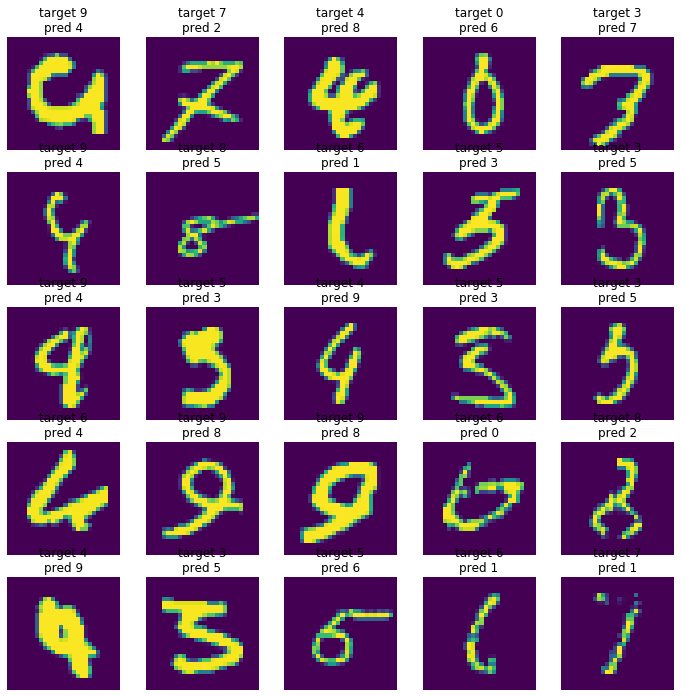

In [0]:
num_images = 25
fig = plt.figure(figsize=(12, 12))
for idx, (image, pred, target) in enumerate(misclassified2[:num_images]):
    image, pred, target = image.cpu().numpy(), pred.cpu(), target.cpu()
    ax = fig.add_subplot(5, 5, idx+1)
    ax.axis('off')
    ax.set_title('target {}\npred {}'.format(target.item(), pred.item()), fontsize=12)
    ax.imshow(image.squeeze())
plt.show()

**Misclassification :L1 Regularization**

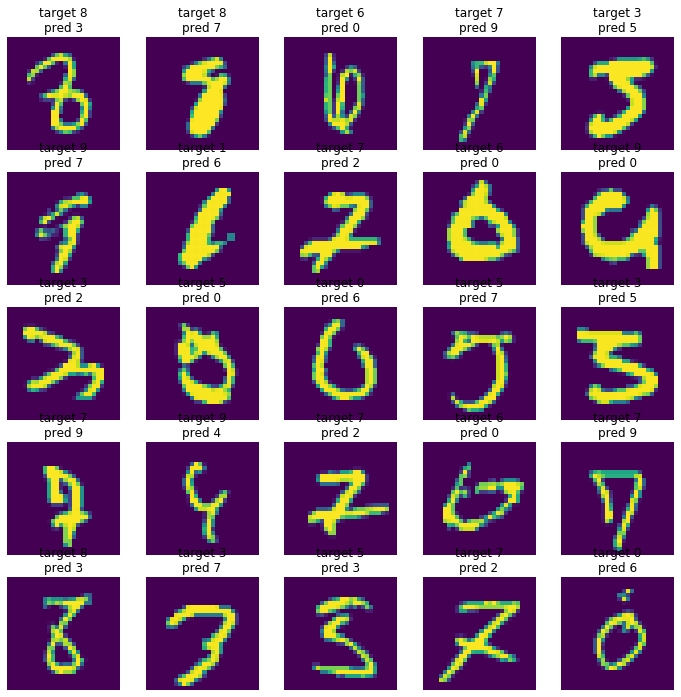

In [0]:
misclassified3 = get_misclassified(model3, device3,test_loader3)
num_images = 25
fig = plt.figure(figsize=(12, 12))
for idx, (image, pred, target) in enumerate(misclassified3[:num_images]):
    image, pred, target = image.cpu().numpy(), pred.cpu(), target.cpu()
    ax = fig.add_subplot(5, 5, idx+1)
    ax.axis('off')
    ax.set_title('target {}\npred {}'.format(target.item(), pred.item()), fontsize=12)
    ax.imshow(image.squeeze())
plt.show()